<a href="https://colab.research.google.com/github/Jeremy26/tracking_course/blob/master/1_YOLO_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the YOLO Workshop!

In this workshop, we will learn how to use the YOLO algorithm for object detection

## Import the YOLO files and the images

In [1]:
!wget https://thinkautonomous-tracking.s3.eu-west-3.amazonaws.com/tracking.zip && unzip tracking.zip

--2022-03-02 15:13:25--  https://thinkautonomous-tracking.s3.eu-west-3.amazonaws.com/tracking.zip
Resolving thinkautonomous-tracking.s3.eu-west-3.amazonaws.com (thinkautonomous-tracking.s3.eu-west-3.amazonaws.com)... 52.95.156.36
Connecting to thinkautonomous-tracking.s3.eu-west-3.amazonaws.com (thinkautonomous-tracking.s3.eu-west-3.amazonaws.com)|52.95.156.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 831435151 (793M) [application/zip]
Saving to: ‘tracking.zip’

tracking.zip        100%[===================>] 792.92M  22.2MB/s    in 37s     

2022-03-02 15:14:03 (21.2 MB/s) - ‘tracking.zip’ saved [831435151/831435151]

Archive:  tracking.zip
   creating: tracking/
  inflating: __MACOSX/._tracking     
  inflating: tracking/model640.pt    
  inflating: __MACOSX/tracking/._model640.pt  
   creating: tracking/Yolov4/
  inflating: __MACOSX/tracking/._Yolov4  
  inflating: tracking/siamese_net.py  
  inflating: __MACOSX/tracking/._siamese_net.py  
   creating:

In [2]:
!python3 -m pip install yolov4==2.0.2 # After Checking, YOLO 2.0.2 works without modifying anything. Otherwise keep 1.2.1

  Created wheel for yolov4: filename=yolov4-2.0.2-py3-none-any.whl size=39757 sha256=6ffbd89bcd0a88b8686f232b0a6cae8ec5611675cf8c11099ae784c914b31739
  Stored in directory: /root/.cache/pip/wheels/a6/ef/cb/2a9464b7d9903f97dc6ff06efc72e5b793e07116adca7e8907
Successfully built yolov4


In [3]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## Read an Image

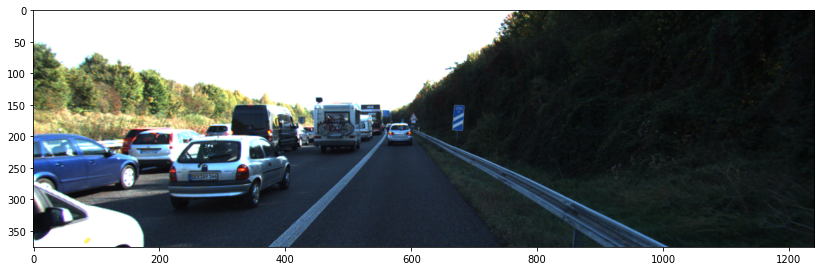

In [28]:
img = cv2.cvtColor(cv2.imread("tracking/data/0000000230.png"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14,7))
plt.imshow(img)
plt.show()

## Build a Basic YOLO Model

In [7]:
from yolov4.tf import YOLOv4
import tensorflow as tf
import time

yolo = YOLOv4(tiny=False)
yolo.classes = "tracking/Yolov4/coco.names"
yolo.make_model()
yolo.load_weights("tracking/Yolov4/yolov4.weights", weights_type="yolo")

Call tf.config.experimental.set_memory_growth(GPU0, True)


## Detect Objects in 21 Lines

In [29]:
def run_obstacle_detection(img):
    resized_image = yolo.resize_image(img)
    resized_image = resized_image / 255. # 0 ~ 255 to 0.0 ~ 1.0
    input_data = resized_image[np.newaxis, ...].astype(np.float32)
    candidates = yolo.model.predict(input_data)
    _candidates = []
    result = img.copy()
    for candidate in candidates:
        batch_size = candidate.shape[0]
        grid_size = candidate.shape[1]
        _candidates.append(tf.reshape(candidate, shape=(1, grid_size * grid_size * 3, -1)))
        candidates = np.concatenate(_candidates, axis=1)
        pred_bboxes = yolo.candidates_to_pred_bboxes(candidates[0], iou_threshold=0.35, score_threshold=0.50)
        pred_bboxes = pred_bboxes[~(pred_bboxes==0).all(1)] #https://stackoverflow.com/questions/35673095/python-how-to-eliminate-all-the-zero-rows-from-a-matrix-in-numpy?lq=1
        pred_bboxes = yolo.fit_pred_bboxes_to_original(pred_bboxes, img.shape)
        result = yolo.draw_bboxes(img, pred_bboxes)
    return result, pred_bboxes

0.12854647636413574


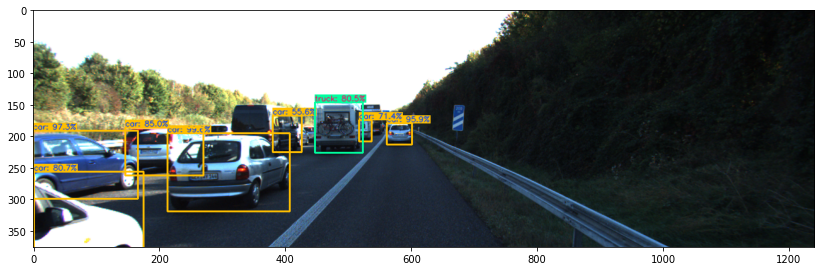

In [30]:
start_time = time.time()
result, pred_bboxes = run_obstacle_detection(img)
print(time.time() - start_time)
plt.figure(figsize=(14,7))
plt.imshow(result)
plt.show() 

## Analyze the Boxes

In [10]:
print(len(pred_bboxes))
print(pred_bboxes)

8
[[0.25042281 0.68397322 0.15753165 0.33179954 2.         0.99559271]
 [0.06742318 0.6519978  0.13407847 0.28940922 2.         0.97289556]
 [0.46866542 0.52169171 0.03267742 0.0953547  2.         0.95860821]
 [0.16783272 0.59679678 0.10074007 0.2048339  2.         0.84975404]
 [0.07116245 0.86740445 0.14166756 0.37380721 2.         0.8069461 ]
 [0.42496109 0.5102062  0.01626652 0.09503196 2.         0.71382463]
 [0.32492921 0.52375046 0.03764984 0.15509942 2.         0.55637252]
 [0.39099908 0.49591919 0.06148466 0.21361088 7.         0.80458683]]


In [11]:
h, w, _ = img.shape
idx = 4

testing_box = pred_bboxes[idx]
print("original box", testing_box)
print("center_x:",testing_box[0]*w)
print("center_y",testing_box[1]*h)
print("width:", testing_box[2]*w)
print("height:",testing_box[3]*h)
print("class:", yolo.classes[int(testing_box[4])])
print("confidence:", testing_box[5])

original box [0.07116245 0.86740445 0.14166756 0.37380721 2.         0.8069461 ]
center_x: 88.31259714066982
center_y 326.14407497644424
width: 175.8094416409731
height: 140.5515096411109
class: car
confidence: 0.8069460988044739


## Draw the Boxes again for Tracking

We're not exactly done. The point of the course isn't to draw these rectangles, but to draw rectangles with specific IDs.

For that, we'll need to assign a color per bounding box, and redraw the boxes.

In [15]:
def convert_box(center_x, center_y, width, height):
    """
    Optional
    """
    left = int(center_x - width/2)
    right = int(center_x + width/2)
    top = int(center_y - height/2)
    bottom = int(center_y + height/2)
    return left, top, right, bottom

In [31]:
def draw_boxes(pred_bboxes, image, color=(255,79,23)):
    h, w, _ = image.shape
    for box in pred_bboxes:
        left, top, right, bottom = convert_box(box[0]*w, box[1]*h, box[2]*w, box[3]*h)
        label = yolo.classes[int(box[4])]
        cv2.rectangle(image, (left, top), (right, bottom), color, thickness=11)
        cv2.putText(image, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=3)
    return image

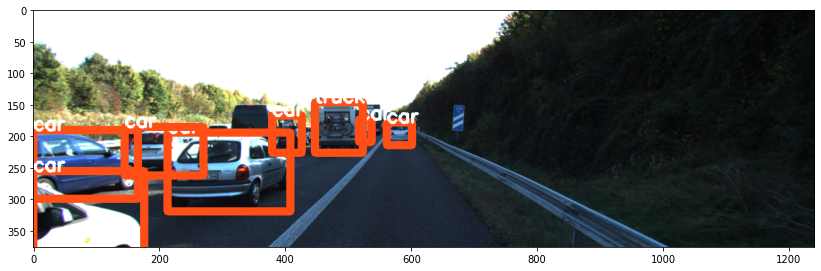

In [32]:
plt.figure(figsize=(14,7))
plt.imshow(draw_boxes(pred_bboxes, img))
plt.show()

## Reach Our Limit — Draw Boxes with a Random Index

In [33]:
def id_to_color(idx):
    """
    Random function to convert an id to a color
    Do what you want here but keep numbers below 255
    """
    blue = idx*5 % 256
    green = idx*12 %256
    red = idx*23 %256
    return (red, green, blue)

def draw_boxes_color(pred_bboxes, image):
    h, w, _ = image.shape
    for i, box in enumerate(pred_bboxes):
        left, top, right, bottom = convert_box(box[0]*w, box[1]*h, box[2]*w, box[3]*h)
        label = yolo.classes[int(box[4])]
        cv2.rectangle(image, (left, top), (right, bottom), id_to_color(i*10), thickness=11)
        cv2.putText(image, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=3)
    return image

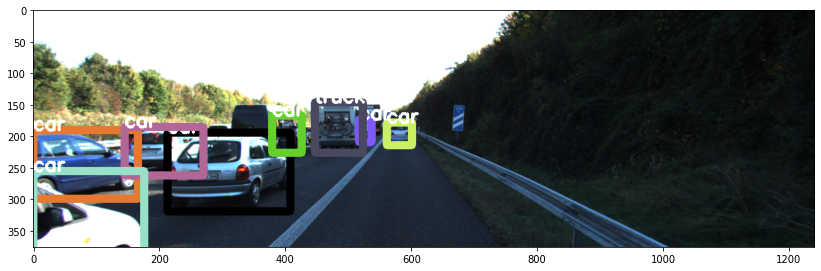

In [34]:
plt.figure(figsize=(14,7))
plt.imshow(draw_boxes_color(pred_bboxes, img))
plt.show()

## Run on a Video

In [ ]:
import glob 
from tqdm import tqdm

video_images = sorted(glob.glob("tracking/data/*.png"))
result_video = []
for img in tqdm(video_images):
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    _, pred_bboxes = run_obstacle_detection(img)
    img_out = draw_boxes_color(pred_bboxes, img)
    result_video.append(img_out)

In [38]:
out = cv2.VideoWriter('out_yolo.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (img.shape[1],img.shape[0]))

for img in result_video:
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release()

In [25]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('out_yolo.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)